In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix, precision_recall_curve

torch.manual_seed(420)

import warnings
warnings.filterwarnings("ignore")

# Postavka problema

# Istraživanje podataka

In [2]:
df = pd.read_csv("data/rookie_df.csv", low_memory=False)
df

,Unnamed: 0,Year Drafted,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,EFF,target
0,0,2013,70,34.5,16.7,6.1,15.1,40.5,0.8,3.0,...,70.3,1.4,4.8,6.2,6.3,1.9,0.6,3.5,17.6,1
1,1,2013,70,32.3,12.8,4.9,12.8,38.0,1.6,4.8,...,90.3,0.5,2.4,3.0,5.7,0.6,0.1,1.9,12.1,1
2,2,2013,80,31.1,13.8,4.9,11.7,41.9,0.9,2.8,...,78.0,0.5,3.6,4.1,4.1,1.6,0.5,3.2,13.2,1
3,3,2013,82,26.7,8.8,3.1,8.3,37.6,1.2,3.6,...,80.4,0.6,2.2,2.9,1.0,0.6,0.2,1.2,6.7,1
4,4,2013,77,24.6,6.8,2.2,5.4,41.4,0.5,1.5,...,68.3,1.0,3.4,4.4,1.9,0.8,0.8,1.6,9.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419,1419,1980,59,10.1,3.2,1.4,3.1,45.4,0.0,0.1,...,56.4,0.5,0.6,1.0,1.2,0.6,0.1,1.3,2.8,0
1420,1420,1980,47,9.6,2.0,0.7,2.0,35.8,0.0,0.1,...,78.1,0.2,0.7,0.9,1.5,0.5,0.0,0.6,2.9,1
1421,1421,1980,60,8.9,2.8,1.0,3.0,33.0,0.0,0.1,...,73.9,0.5,0.7,1.2,1.3,0.4,0.0,0.6,2.7,0
1422,1422,1980,55,8.4,2.7,1.0,2.5,41.2,0.0,0.1,...,43.5,0.5,1.2,1.7,0.3,0.4,0.4,0.6,2.6,0


In [3]:
df.columns

Index(['Unnamed: 0', 'Year Drafted', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%',
       '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB',
       'AST', 'STL', 'BLK', 'TOV', 'EFF', 'target'],
      dtype='object')

### Biranje atributa [NEEDS REWRITING]

U datasetu postoje 66 atributa za svakog igrača, što je previše. Redukcija prostora atributa će biti vršena u tri koraka:

1. Izbacivanje redundantnih atributa.  _Primer_: Odnos asistencija i izgubljenih lopti (`ast/tov`) je suvišan kada već postoje atributi za broj asistencije i broj izgubljenih lopti
2. Izbacivanje atributa na osnovu iskustvenog zananja. _Primer_: Nepotrebno je da pored škole za koju igra student koristimo kao atribut i konferenciju u kojoj je ta škola
3. Nad ostalim atributima će biti izračunata korelacija sa ciljanim izlazima modela, i biće izabrani najboljih 10

Ovim postupkom će model biti manji, i samim tim će mu biti smanjena mogućnost overfittovanja.

Cilj mreže je predviđanje da li će neki pik biti izabran na draftu. Svi odbirci koji imaju vrednost u `pick` koloni biće označeni kao pozitivni, dok će ostali biti označeni kao negativni

In [4]:
# Choose valuable features
clean_df = df[['GP', 'MIN', 'PTS', 'FGM', 'FGA',
       '3P Made', '3PA', 'FTM', 'FTA', 'OREB', 'DREB',
       'AST', 'STL', 'BLK', 'TOV', 'EFF', 'target']].copy()
clean_df.dropna(inplace=True)

In [5]:
# Describe features
clean_df.describe()

,GP,MIN,PTS,FGM,FGA,3P Made,3PA,FTM,FTA,OREB,DREB,AST,STL,BLK,TOV,EFF,target
count,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000,1424.000000
mean,61.131320,17.483216,6.735323,2.602247,5.799930,0.238062,0.740520,1.295084,1.822121,1.034059,2.041011,1.497331,0.601826,0.388764,1.188062,7.381461,0.601124
std,16.828774,8.265126,4.324453,1.666493,3.545943,0.385139,1.057448,0.981904,1.322281,0.786525,1.371742,1.445766,0.406427,0.471463,0.714481,4.621797,0.489839
min,11.000000,3.100000,0.700000,0.300000,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.100000,0.200000,0.000000
25%,48.000000,10.900000,3.600000,1.400000,3.200000,0.000000,0.000000,0.600000,0.900000,0.500000,1.000000,0.500000,0.300000,0.100000,0.700000,3.800000,0.000000
50%,64.000000,15.950000,5.500000,2.100000,4.800000,0.000000,0.200000,1.000000,1.500000,0.800000,1.700000,1.000000,0.500000,0.200000,1.000000,6.350000,1.000000
75%,77.000000,23.000000,8.800000,3.400000,7.500000,0.300000,1.100000,1.700000,2.300000,1.400000,2.700000,1.900000,0.800000,0.500000,1.500000,9.800000,1.000000
max,82.000000,40.900000,28.200000,10.200000,19.800000,2.300000,6.500000,7.700000,10.200000,5.400000,9.600000,10.600000,2.500000,5.000000,4.400000,30.600000,1.000000


In [6]:
# Calculate percentage of True datapoints
value_cnts = clean_df["target"].value_counts()
print(f"Dataset sadrži {len(clean_df)} odbiraka, od čega su {value_cnts[1] / len(clean_df) * 100:0.2f}% pozitivni na koronu/COVID-19/Komunjarski Grip.")

Dataset sadrži 1424 odbiraka, od čega su 60.11% pozitivni na koronu/COVID-19/Komunjarski Grip.


## Podela na trening i test

In [7]:
from sklearn.model_selection import train_test_split

# Do train/test split
train_df, valid_df = train_test_split(clean_df, train_size=.7, random_state=420)

### Normalizacija dataseta

In [8]:
from sklearn.preprocessing import StandardScaler

input_columns = clean_df.columns[:-1]

# Fit scaler
scaler = StandardScaler()
scaler.fit(train_df[input_columns].values)

# Normalize train data
norm_train_np = scaler.transform(train_df[input_columns].values)
norm_train_df = pd.DataFrame(norm_train_np, columns=input_columns)
norm_train_df["target"] = train_df["target"].values

# Normalize validation data
norm_valid_np = scaler.transform(valid_df[input_columns])
norm_valid_df = pd.DataFrame(norm_valid_np, columns=input_columns)
norm_valid_df["target"] = valid_df["target"].values

# Definisanje modela

Model će se sastojati od duboke neuronske mreže, sa potpuno povezanim slojevima.
Ulaz u mrežu će biti prethodno izabrani atributi, a izlaz će sadžati jedan neuron čiji izlaz predstavlja uverenost modela da će ulazni igrač biti NBA pik.

#### Dataset klasa

Prvi korak predstavlja definisanje klase koja će dohvatati podatke u _batch_-evima tokom treniranja.

In [9]:
from torch.utils.data import Dataset, DataLoader

class NBA_Dataset(Dataset):
    """Class for holding data of NCAA players and if there were picked for the NBA."""

    def __init__(self, df: pd.DataFrame) -> None:
        """Initialize torch Dataset based on pandas Dataframe."""
        super(NBA_Dataset, self).__init__()

        # Take all except the last column as inputs
        self.inputs = df.values[:, :-1].astype(float)

        # Cast Targets column to numpy
        self.targets = df["target"].values.astype(int)

        # Save dataframe as part of the class
        self.df = df

        # Define dataset length
        self.len = len(df)

    def __getitem__(self, index) -> dict:
        """Return dict with information of datapoint at `index`"""
        # Get input
        input_row = torch.Tensor(self.inputs[index, :])

        # Get output
        target = torch.Tensor([self.targets[index]])

        return {
            "Inputs": input_row,
            "Targets": target,
        }

    def __len__(self):
        """Get dataset length."""
        return self.len

#### Definicija modela

**OVDE SE PISE O TOME STA SVE IMA U MODELU**

In [10]:
import torch.nn as nn

class NBA_Draft_Predictor(nn.Module):
    """Class for prediction NCAA player chances of being piked in NBA draft."""

    def __init__(self, layer_sizes: list, activation_function: nn.Module = None) -> None:
        """Initialize fully-connected model based on input parameters."""
        super(NBA_Draft_Predictor, self).__init__()

        assert len(layer_sizes)

        # Check if activation function is not defined
        if activation_function is None:
            activation_function = nn.ReLU()

        # Define activation function
        self.activation = activation_function

        # Layers init
        layer_list = []

        # Define layer sizes
        for in_size, out_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layer_list.append(nn.Linear(in_size, out_size))
            # layer_list.append(nn.Tanh())

        # Cast layer list to nn.Module
        self.fc_layers = nn.ModuleList(layer_list)

    def forward(self, X) -> torch.Tensor:
        """Define network behavior when called on data."""
        # Pass data trough fully-connected layers
        for layer in self.fc_layers:
            X = layer(X)
        
        # Calculate output probability as sigmoid of output
        output_probability = torch.sigmoid(X)

        return output_probability

# Trening

In [11]:
train_dataset = NBA_Dataset(train_df)

train_parameters = {
    "batch_size": 64,
    "shuffle": True,
    "num_workers": 1,
}

training_loader = DataLoader(train_dataset, **train_parameters)

# Validation dataset
valid_dataset = NBA_Dataset(valid_df)

valid_parameters = {
    "batch_size": 64,
    "shuffle": False,
    "num_workers": 1,
}

validation_loader = DataLoader(valid_dataset, **valid_parameters)

#### Inicijalizacija treninga

**Ovde objasniti zasto smo odabrali Adam optimajzer i BCE loss funkciju**

In [12]:
CLASS_THR = .5
def train_network(model: NBA_Draft_Predictor, optimizer, training_objects: dict) -> dict:
    
    # Unpack dictionaries
    loss_function = training_objects["Loss Function"]
    training_loader = training_objects["Train Dataloader"]
    validation_loader = training_objects["Valid Dataloader"]
    num_of_epochs = training_objects["Epochs"]

    training_loss = []
    training_acc = []

    validation_loss = []
    validation_acc = []

    for _ in range(1, num_of_epochs + 1):

        # Run epoch of training
        train_epoch_loss = 0.0
        train_epoch_acc = 0.0

        model.train()

        for batch in training_loader:
            
            # Load batch
            X = batch["Inputs"]
            Y = batch["Targets"]

            optimizer.zero_grad()

            # Run forward pass
            probabilities = model(X)

            # Calculate loss
            loss = loss_function(probabilities, Y)
            train_epoch_loss += loss.item()

            # Update model
            loss.backward()
            optimizer.step()

            # Calculate predictions
            predictions = probabilities >= CLASS_THR

            # Log true predictions
            train_epoch_acc += sum(predictions == Y)

        train_epoch_loss /= len(training_loader)
        train_epoch_acc /= len(training_loader.dataset)

        training_loss.append(train_epoch_loss)
        training_acc.append(train_epoch_acc)

        # VALIDATION
        valid_epoch_loss = 0.0
        valid_epoch_acc = 0.0

        model.eval()

        for batch in validation_loader:
            
            # Load batch
            X = batch["Inputs"]
            Y = batch["Targets"]

            # Run forward pass
            probabilities = model(X)

            # Calculate loss
            loss = loss_function(probabilities, Y)
            valid_epoch_loss += loss.item()

            # Update model
            loss.backward()

            # Calculate predictions
            predictions = probabilities >= CLASS_THR

            # Log true predictions
            valid_epoch_acc += sum(predictions == Y)

        valid_epoch_loss /= len(validation_loader)
        valid_epoch_acc /= len(validation_loader.dataset)

        validation_loss.append(valid_epoch_loss)
        validation_acc.append(valid_epoch_acc)

    probabilities = []
    predictions = []
    targets = []

    # Evaluate final model
    for batch in validation_loader:
        
        # Load batch
        X = batch["Inputs"]
        Y = batch["Targets"]

        # Run forward pass
        batch_probabilities = model(X)
        batch_predictions = batch_probabilities >= CLASS_THR

        probabilities.extend(batch_probabilities.detach().numpy().flatten().tolist())
        predictions.extend(batch_predictions.detach().numpy().flatten().tolist())
        targets.extend(Y.detach().numpy().flatten().tolist())


    training_parameters = {
        "train loss": training_loss,
        "train acc": training_acc,
        "validation loss": validation_loss,
        "validation acc": validation_acc,
        "Prediction probabilities": probabilities,
        "Predictions": predictions,
        "Targets": targets,
    }

    return model, training_parameters

### Testing train function

In [13]:
from torch.nn import BCELoss
from torch.optim import Adam

# Initialize loss function as Binary Cross Entropy
loss_function = BCELoss()

# Define learning rate
lr = 3e-4

# Define number of epochs
num_of_epochs = 400

# Wrap training loaders into dictionary
training_objects = {
    "Loss Function": loss_function,
    "Train Dataloader": training_loader,
    "Valid Dataloader": validation_loader,
    "Epochs": num_of_epochs,
}

Goodfit

In [14]:
model = NBA_Draft_Predictor([train_dataset.inputs.shape[1], 20, 4, 1])
optimizer = Adam(params=model.parameters(), lr=lr)
final_model, final_results = train_network(model, optimizer, training_objects=training_objects)

underfit

In [15]:
underfit_model = NBA_Draft_Predictor([train_dataset.inputs.shape[1], 1])
underfit_optimizer = Adam(params=underfit_model.parameters(), lr=lr)
underfit_model, underfit_results = train_network(underfit_model, underfit_optimizer, training_objects=training_objects)

overfit

In [16]:
overfit_model = NBA_Draft_Predictor([train_dataset.inputs.shape[1], 20, 30, 20, 1])
overfit_optimizer = Adam(params=overfit_model.parameters(), lr=lr * 100)
overfit_model, overfit_results = train_network(overfit_model, overfit_optimizer, training_objects=training_objects)

#### Result presentation

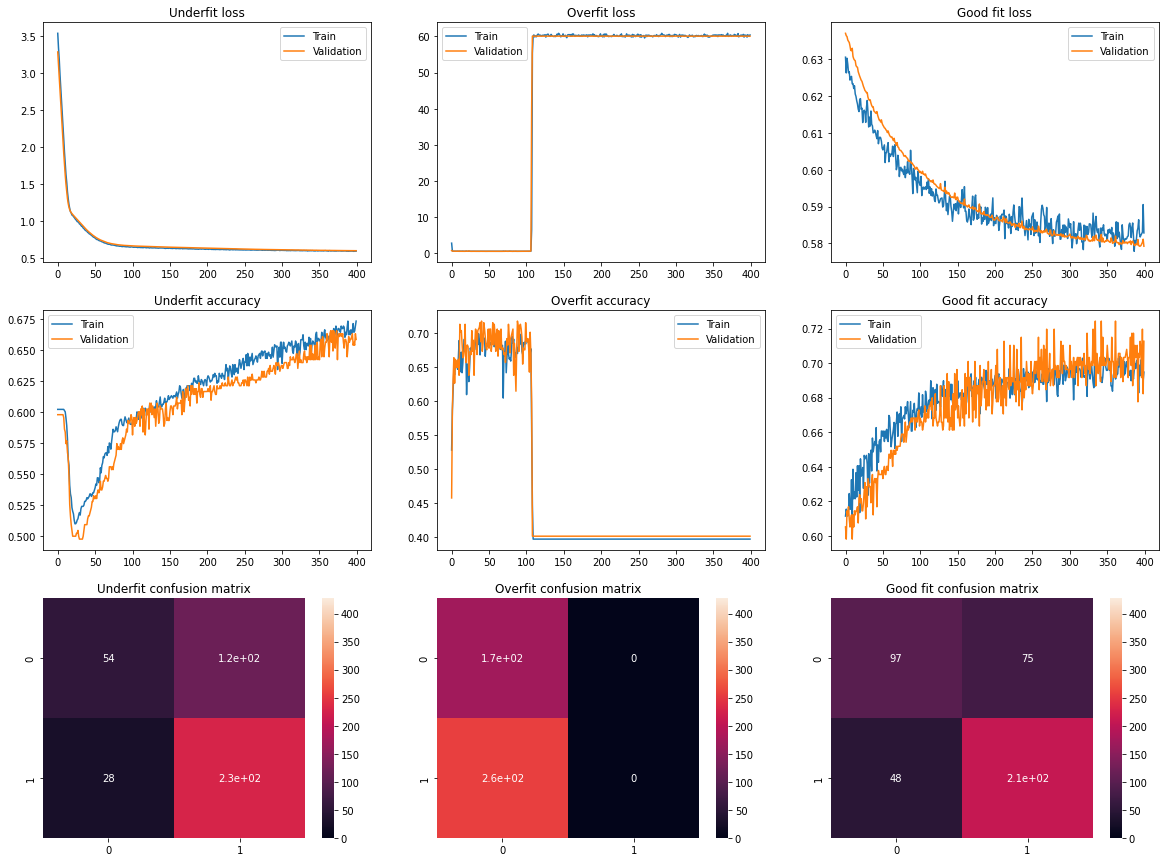

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
title_labels = ["Underfit", "Overfit", "Good fit"]

# Graphs
for idx, results in enumerate([underfit_results, overfit_results, final_results]):

    # Plot loss
    ax[0, idx].plot(results["train loss"], label="Train")
    ax[0, idx].plot(results["validation loss"], label="Validation")
    ax[0, idx].legend()
    ax[0, idx].set_title(f"{title_labels[idx]} loss")

    # Plot accuracy
    ax[1, idx].plot(results["train acc"], label="Train")
    ax[1, idx].plot(results["validation acc"], label="Validation")
    ax[1, idx].legend()
    ax[1, idx].set_title(f"{title_labels[idx]} accuracy")

    # Plot confusion matrix
    sb.heatmap(confusion_matrix(results["Targets"], results["Predictions"]), vmin=0, vmax=len(validation_loader.dataset), annot=True, ax=ax[2, idx])
    ax[2, idx].set_title(f"{title_labels[idx]} confusion matrix")

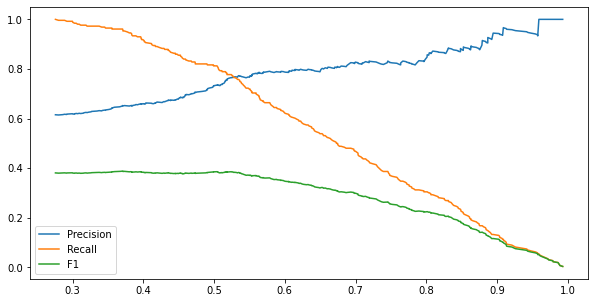

In [19]:
prec, recall, thrs = precision_recall_curve(final_results["Targets"], final_results["Prediction probabilities"])
f1 = prec * recall / (prec + recall)

_, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(thrs, prec[:-1], label="Precision")
plt.plot(thrs, recall[:-1], label="Recall")
plt.plot(thrs, f1[:-1], label="F1")
plt.legend()

### Hyperparameter sweep

In [20]:
import optuna

In [21]:
def objective_function(trial: optuna.trial.Trial):

    lr = trial.suggest_loguniform("learning_rate", 1e-6, 1e-4)
    num_of_layers = trial.suggest_int("num_of_layers", 0, 4)

    layer_sizes = [train_dataset.inputs.shape[1]]

    for idx in range(num_of_layers):
        layer_sizes.append(trial.suggest_int(f"layer_{idx}", 4, 30))
    layer_sizes.append(1)

    model = NBA_Draft_Predictor(layer_sizes)
    optimizer = Adam(model.parameters(), lr=lr)

    _, results = train_network(model, optimizer, training_objects)

    return max(results["validation acc"])

In [22]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective_function, n_trials=15)

[I 2022-06-24 14:08:39,682] A new study created in memory with name: no-name-81caad61-14df-4629-9ad3-3e096106f404
[I 2022-06-24 14:10:03,674] Trial 0 finished with value: 0.6238317489624023 and parameters: {'learning_rate': 5.81387259550986e-05, 'num_of_layers': 0}. Best is trial 0 with value: 0.6238317489624023.


# Tabela modela
[in, 20, 1], lr = 3e-4 | ACC : <69
[in, 20, 4, 1], lr = 3e-4 | ACC : 72%

## Redukcija dimenzionalnosti

In [ ]:
cov_mat = clean_df.corr().to_numpy()[:-1, :-1]

# Calculate eig
eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)

# Sort indexes

# Take vector subset
num_of_components = 5
eigv_subset = eigen_vectors[:, -num_of_components:]

# # Reduce X
# X_reduced = np.dot(eigv_subset.T, X.T).T

In [ ]:
X = clean_df.to_numpy()[:, :-1]

X_reduced = np.dot(eigv_subset.T, X.T).T
X_reduced.shape

(1424, 5)

In [ ]:
reduced_df = pd.DataFrame(X_reduced, columns=[f"f{idx}" for idx in range(num_of_components)])
reduced_df["target"] = clean_df["target"]
reduced_df

,f0,f1,f2,f3,f4,target
0,32.720628,-54.814642,-1.875326,2.777260,-48.837056,1
1,32.526022,-56.727047,-0.624926,5.207448,-41.031737,1
2,38.117593,-63.672355,-2.190177,2.440594,-44.525804,1
3,39.768680,-66.777725,-0.513493,2.264519,-35.606190,1
4,35.700192,-63.340263,-1.817067,-0.174656,-33.835434,1
...,...,...,...,...,...,...
1419,28.362832,-48.242262,-3.141612,-0.148563,-19.467689,0
1420,22.049302,-38.856705,-2.616861,0.004085,-15.836670,1
1421,29.180113,-48.797378,-3.180166,-0.383590,-19.061732,0
1422,26.768268,-44.703373,-2.267087,-0.982788,-17.713347,0
